# BTL3 môn Học Máy, mã môn học CO3117 - Học máy với dữ liệu hình ảnh
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |


## **Dataset**
Dữ liệu cho collab này bao gồm 6862 hình ảnh về thời tiết. Bao gồm 11 loại:
+ sương (gồm 698 ảnh)
+ sương mù/khói bụi (gồm 851 ảnh)
+ sương giá (gồm 475 ảnh)
+ men (gồm 639 ảnh)
+ mưa đá (gồm 591 ảnh)
+ sét (gồm 377 ảnh)
+ mưa (gồm 526 ảnh)
+ cầu vồng (gồm 232 ảnh)
+ sương muối (gồm 1160 ảnh)
+ bão cát (gồm 692 ảnh)
+ tuyết (gồm 621 ảnh)

Dữ liệu này được lấy tại [kraggle](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset).

## **Nội dung**
File collab này áp dụng pipeline học máy truyền thống cho bộ dữ liệu.

# Correct Folders

In [1]:
%cd ..

c:\Users\ADMIN\Downloads\BTLML\BTL3


# Imports

In [2]:
!pip install -r requirement.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch
from torchvision import transforms


from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# from modules.module import*
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [4]:
# Import transformer based image feature extractor
# We do 3 models here, Deit, Dinov2 and Swin
# Featuring different technniques
# These 3 should run fine in google collab

# Runtime : ~5s the first time, 1s every time onwards

# pre-processings
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = transforms
T = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), antialias=True),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Deit (Data-efficient Image Transformer)
# Vision Transformer with distillation token
# this has a tiny model but we will use the small one (for maybe better result)
deit_model = timm.create_model('deit_small_patch16_224', pretrained=True)
deit_model.reset_classifier(0)  # remove head for feature extraction

deit_model = deit_model.to(device).eval()
print("Deit imported")

# Dinov2
# ViT backbone, trained self-supervised
# Pretrained weights from facebook
from transformers import AutoImageProcessor, AutoModel
dinov2_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-small")

print("Dinov2 imported")

# Swin tiny
# Windowed attention
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
swin_model.reset_classifier(0)
swin_model = swin_model.to(device).eval()

print("Swin imported")

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Deit imported


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dinov2 imported
Swin imported


# Fetching data

In [5]:
import kagglehub
data_path=kagglehub.dataset_download(handle="jehanbhathena/weather-dataset")+"/dataset"

In [6]:
os.listdir(data_path)

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

# Preprocessing

In [7]:
image_info = []

for label in os.listdir(data_path):
    folder = os.path.join(data_path, label)
    if not os.path.isdir(folder):
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        h, w, c = img.shape
        image_info.append({
            "label": label,
            "width": w,
            "height": h,
            "channels": c,
            "url": img_path
        })

In [8]:
df = pd.DataFrame(image_info)
df.head()

label  width  height  channels  \
0   dew    950     675         3   
1   dew    871     578         3   
2   dew    806     564         3   
3   dew   1200     797         3   
4   dew    947     592         3   

                                                 url  
0  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
1  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
2  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
3  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
4  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...

In [9]:
print(df.describe())              # Thống kê cơ bản
print(df["channels"].value_counts())  # RGB hay grayscale

             width       height  channels
count  6860.000000  6860.000000    6860.0
mean    520.024781   373.845044       3.0
std     352.069907   251.453466       0.0
min     117.000000    91.000000       3.0
25%     400.000000   255.000000       3.0
50%     400.000000   280.000000       3.0
75%     500.000000   400.000000       3.0
max    4863.000000  3174.000000       3.0
channels
3    6860
Name: count, dtype: int64


label
rime         1160
fogsmog       850
dew           698
sandstorm     692
glaze         639
snow          620
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: count, dtype: int64


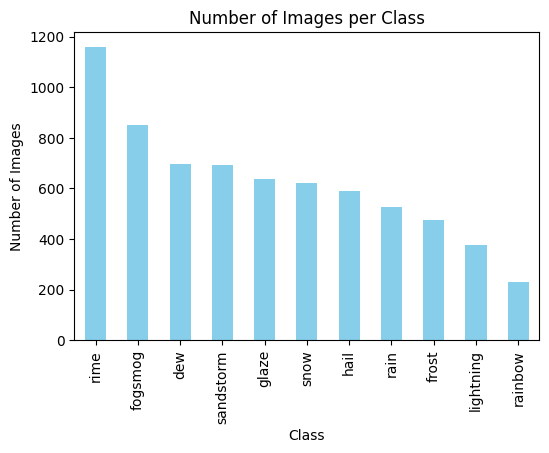

In [10]:
label_counts = df["label"].value_counts()
print(label_counts)
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

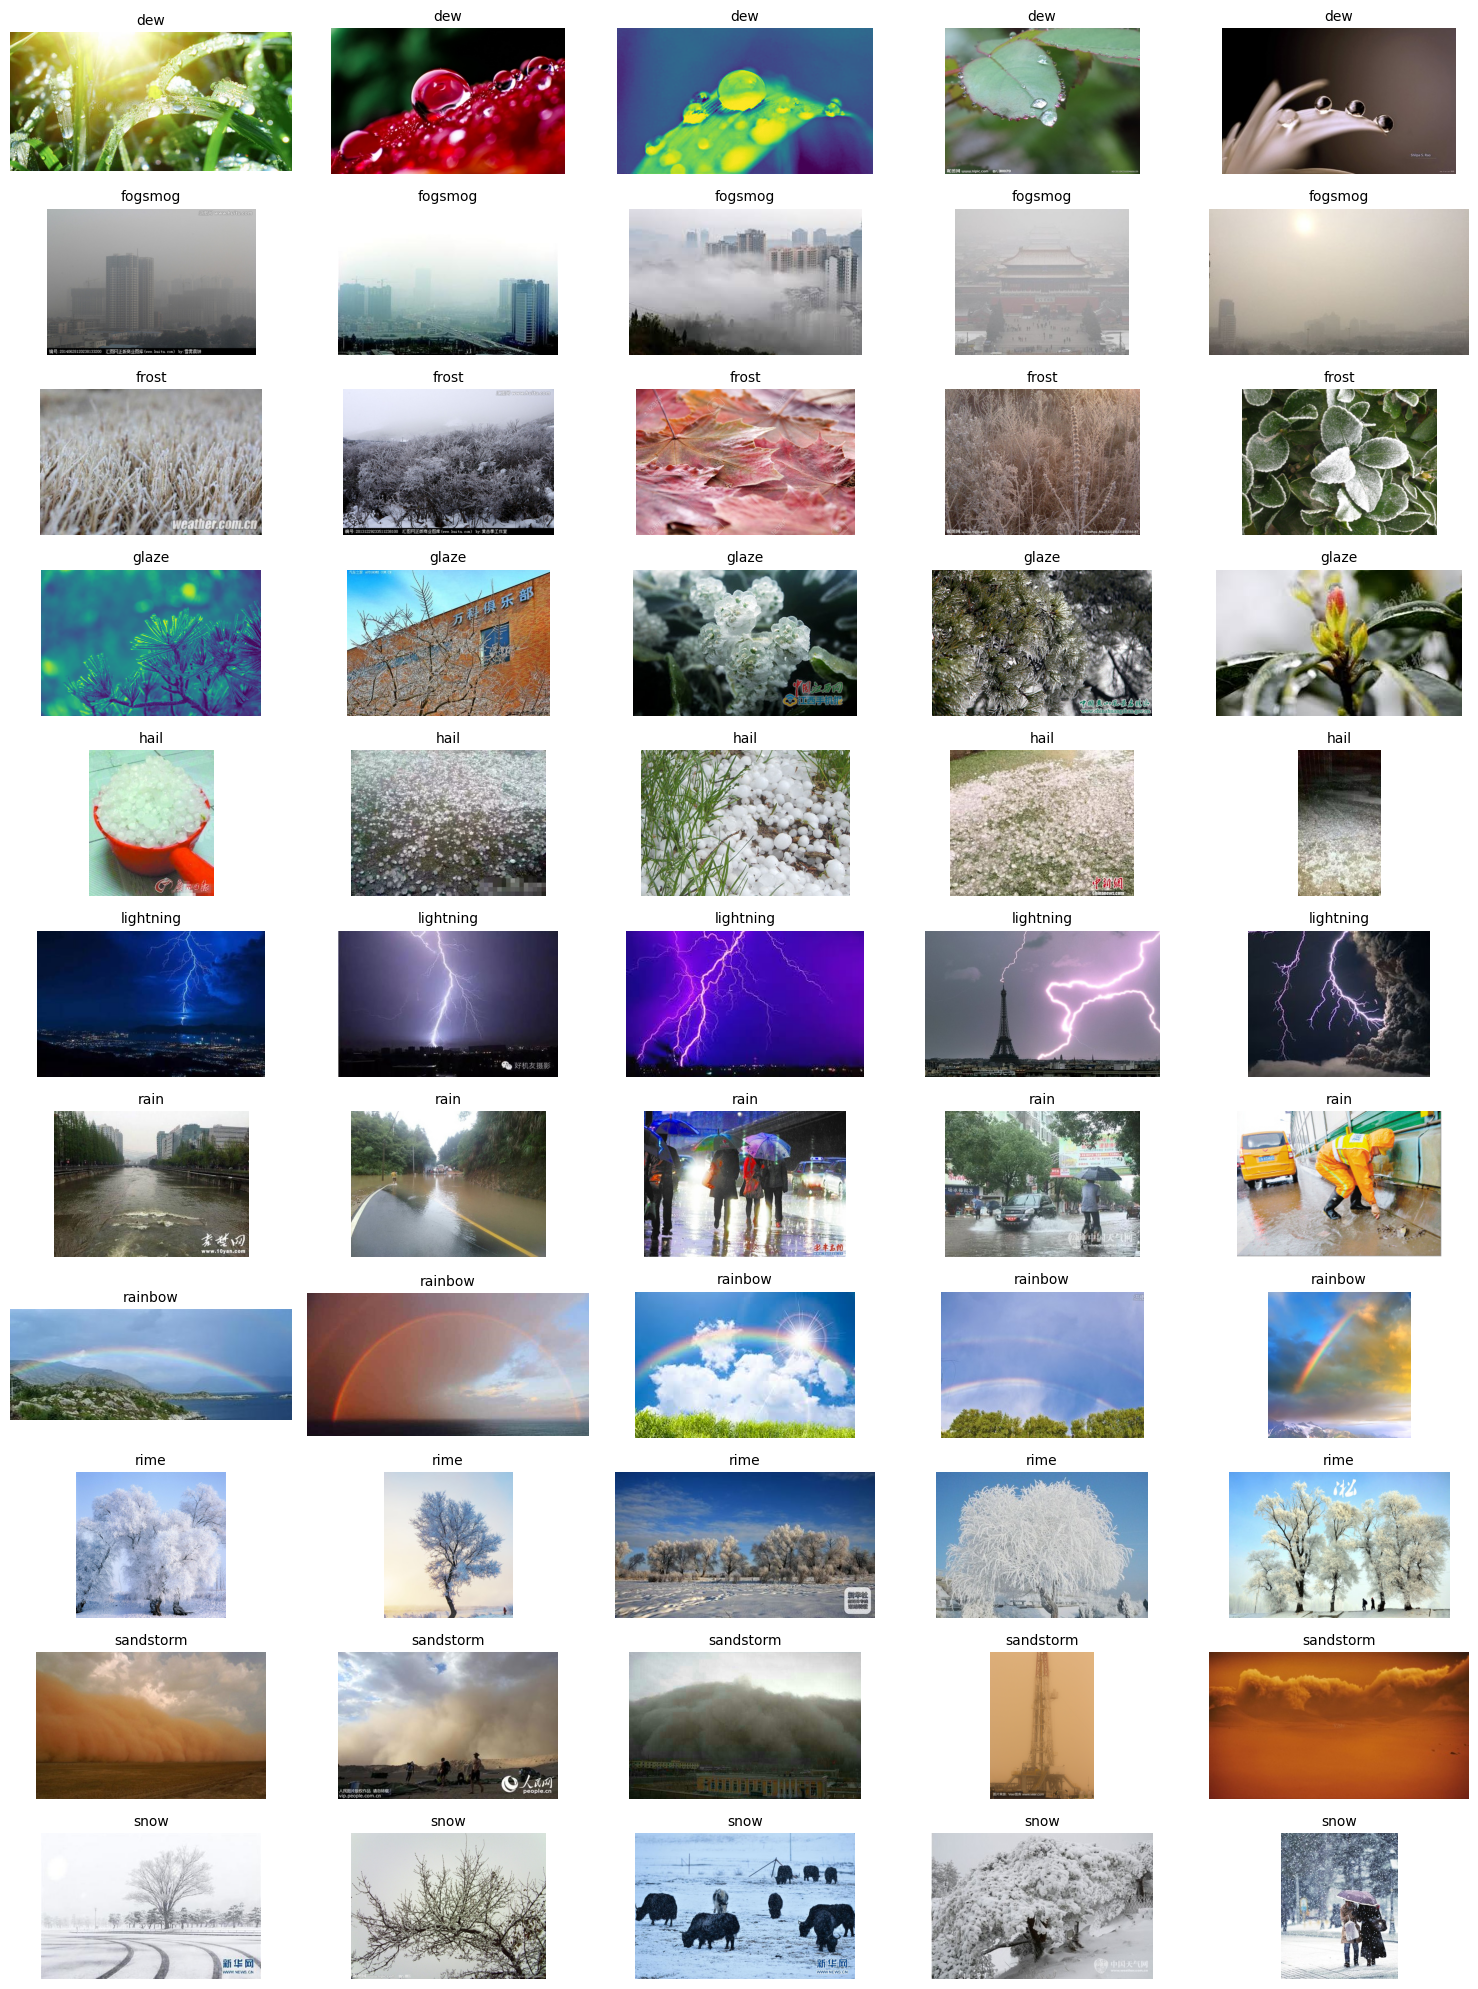

In [11]:
num_samples = 5
plt.figure(figsize=(15, 20))

for class_idx, label in enumerate(df["label"].unique()):
    sample_images = df[df["label"] == label].sample(n=num_samples)
    for i, row in enumerate(sample_images.itertuples()):
        img = plt.imread(row.url)
        ax = plt.subplot(len(df["label"].unique()), num_samples, class_idx * num_samples + i + 1)
        plt.imshow(img)
        plt.title(f"{row.label}", fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

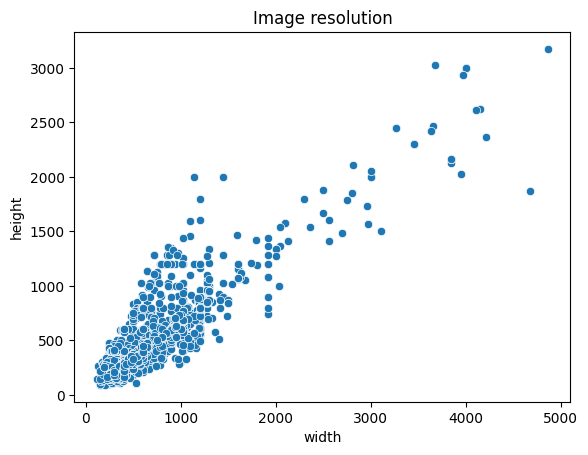

In [12]:
sns.scatterplot(x = "width", y = "height", data = df)
plt.title("Image resolution")

plt.xlabel("width")
plt.ylabel("height")

plt.show()

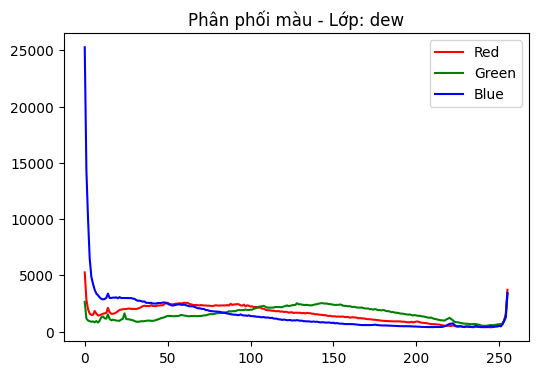

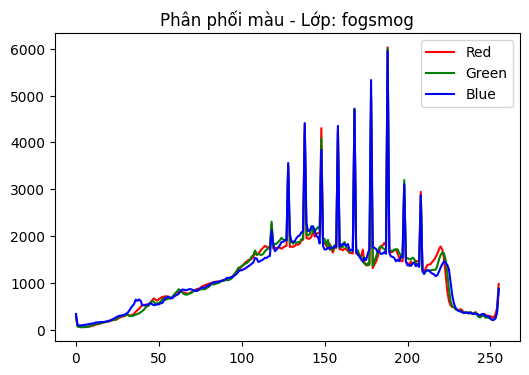

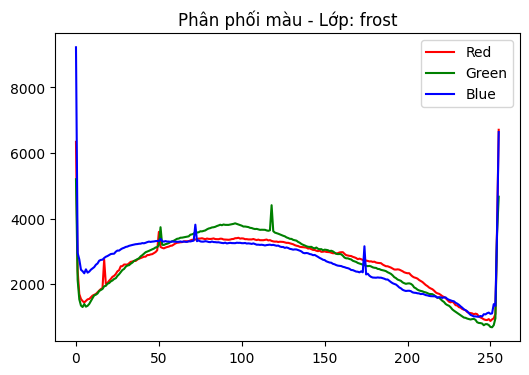

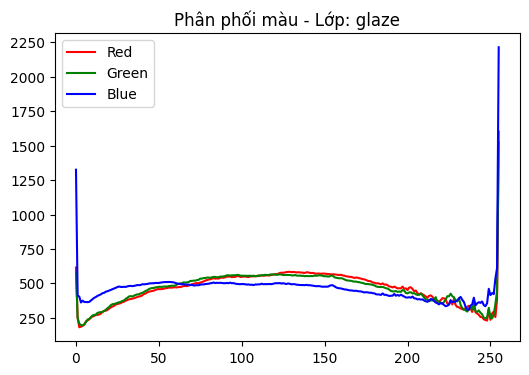

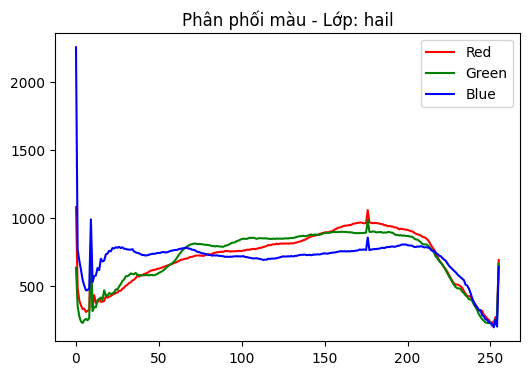

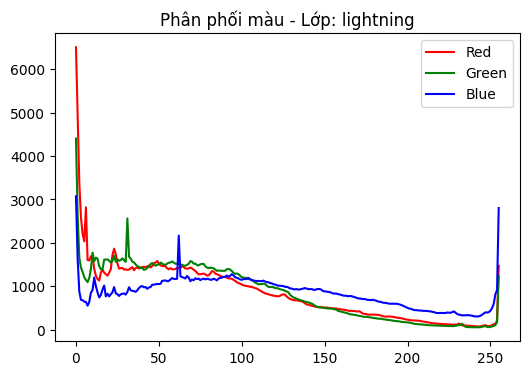

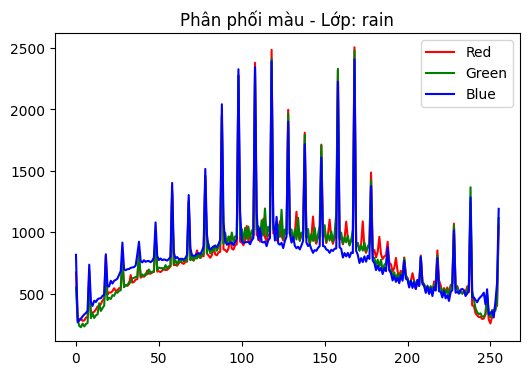

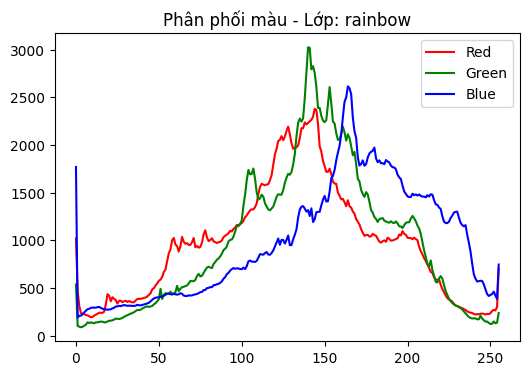

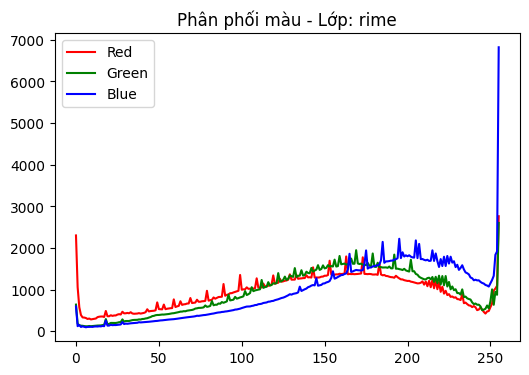

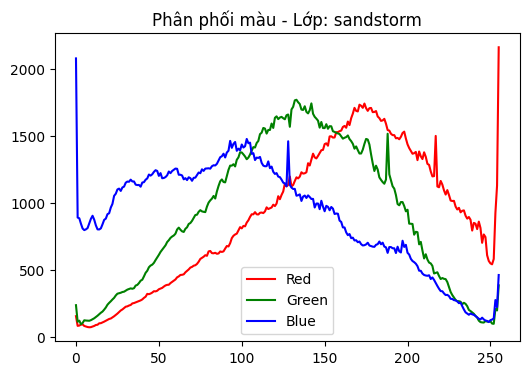

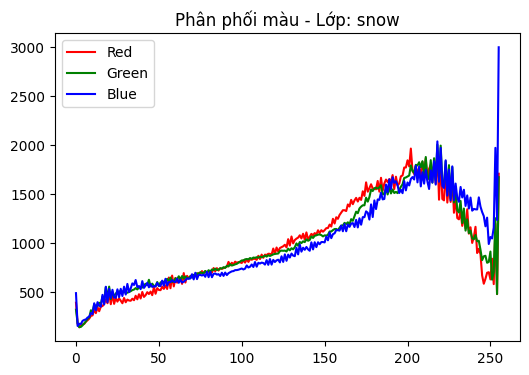

In [13]:
# Danh sách lớp (mỗi thư mục con là 1 lớp)
classes = os.listdir(data_path)

# Lưu histogram trung bình của mỗi lớp
hist_by_class = {cls: {'b': None, 'g': None, 'r': None} for cls in classes}

# Duyệt từng lớp
for cls in classes:
    class_path = os.path.join(data_path, cls)
    b_hist_list, g_hist_list, r_hist_list = [], [], []

    # Duyệt từng ảnh trong lớp
    for file in os.listdir(class_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Tính histogram cho từng kênh
        b_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        g_hist = cv2.calcHist([img], [1], None, [256], [0, 256])
        r_hist = cv2.calcHist([img], [2], None, [256], [0, 256])

        b_hist_list.append(b_hist)
        g_hist_list.append(g_hist)
        r_hist_list.append(r_hist)

    # Trung bình histogram trong lớp
    hist_by_class[cls]['b'] = np.mean(b_hist_list, axis=0)
    hist_by_class[cls]['g'] = np.mean(g_hist_list, axis=0)
    hist_by_class[cls]['r'] = np.mean(r_hist_list, axis=0)

# Vẽ biểu đồ
for cls in classes:
    plt.figure(figsize=(6,4))
    plt.title(f'Phân phối màu - Lớp: {cls}')
    plt.plot(hist_by_class[cls]['r'], color='r', label='Red')
    plt.plot(hist_by_class[cls]['g'], color='g', label='Green')
    plt.plot(hist_by_class[cls]['b'], color='b', label='Blue')
    plt.legend()
    plt.show()

# Feature extraction

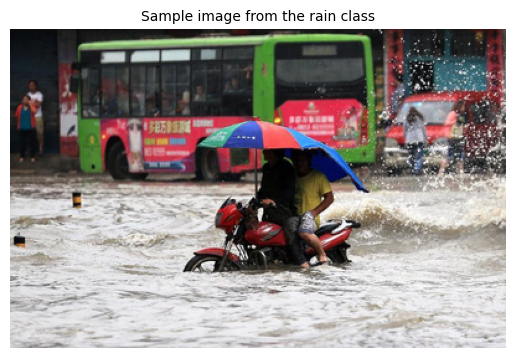

In [14]:
sample_class = "rain"
sample_img_url = df[df["label"] == sample_class].sample(1)["url"]

sample_img = cv2.imread(sample_img_url.values[0])
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.title(f"Sample image from the {sample_class} class", fontsize=10)
plt.axis("off")
plt.show()

In [15]:
model = EfficientNetB3(include_top= False,
                       weights= "imagenet",
                       input_shape= (300,300,3),
                       pooling= 'max')
def extract_features_imgnet(img_path):
    target_size = (300, 300)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    x = np.array(img, dtype=np.float32)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

In [16]:
# Extract features using the 3 imported models

def extract_features_dinov2(img_path):
    # ngl [:, :, ::-1] is quite cryptic
    img = cv2.imread(img_path)[:, :, ::-1]
    inputs = dinov2_processor(images=img, return_tensors="pt")
    with torch.no_grad():
        outputs = dinov2_model(**inputs)
    # outputs.last_hidden_state[:, 0, :] is the CLS token embedding
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

def extract_features_swin(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = T(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feats = swin_model(img)
    return feats.cpu().numpy().flatten()

def extract_features_deit(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = T(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feats = deit_model(img)
    return feats.cpu().numpy().flatten()

In [17]:
# Test feature extraction
feat = extract_features_imgnet(sample_img_url.values[0])
print("Imgnet feature shape:", feat.shape) # (1536,)

feat = extract_features_dinov2(sample_img_url.values[0])
print("Dinov2 feature shape:", feat.shape) # (384,)

feat = extract_features_swin(sample_img_url.values[0])
print("Swin feature shape:", feat.shape) # (764,)

feat = extract_features_deit(sample_img_url.values[0])
print("Deit feature shape:", feat.shape) # (384,)

Imgnet feature shape: (1536,)
Dinov2 feature shape: (384,)
Swin feature shape: (768,)
Deit feature shape: (384,)


In [19]:
# Compute the feature, looooong
features_imgnet, features_dinov2, features_swin, features_deit, labels = [], [], [], [], []

def make_features():
  # Label only stored if all 4 can extract features
  for label in os.listdir(data_path):
      folder = os.path.join(data_path, label)
      if not os.path.isdir(folder):
          continue
      print(f"📂 Đang xử lý lớp: {label}")
      for file in tqdm(os.listdir(folder)):
          img_path = os.path.join(folder, file)

          noErr = True
          feat_imgnet, feat_dinov2, feat_swin, feat_deit = None, None, None, None

          try:
              feat_imgnet = extract_features_imgnet(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - imgnet", file, ":", e)
              noErr = False

          try:
              feat_dinov2 = extract_features_dinov2(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - dinov2", file, ":", e)
              noErr = False

          try:
              feat_swin = extract_features_swin(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - swin", file, ":", e)
              noErr = False

          try:
              feat_deit = extract_features_deit(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - deit", file, ":", e)
              hasErr = True

          if noErr:
              features_imgnet.append(feat_imgnet)
              features_dinov2.append(feat_dinov2)
              features_swin.append(feat_swin)
              features_deit.append(feat_deit)
              labels.append(label)

# Saving/loading features

In [24]:
# Check if the files about to save already exist

# Print current path
print("Current path:", os.getcwd())

paths = [
    "features/label.npy",
    "features/efficientnet.npy",
    "features/dinov2.npy",
    "features/swin.npy",
    "features/deit.npy"
]
everyPathsExist = all(os.path.exists(path) for path in paths)
if everyPathsExist:
    print("Features already saved, loading")
    labels = np.load("features/label.npy", allow_pickle=True)
    features_imgnet = np.load("features/efficientnet.npy")
    features_dinov2 = np.load("features/dinov2.npy")
    features_swin = np.load("features/swin.npy")
    features_deit = np.load("features/deit.npy")
    print("Loaded all")
else:
    # check whats NOT saved
    [print(f"{path} doesnt exist") if not os.path.exists(path) else "" for path in paths]

    print("Features not saved, computing")
    make_features()

    # Check if /features exist and create it
    if not os.path.exists("features"):
        os.makedirs("features")

    # Saves the feature
    labels_arr = np.array(labels)
    np.save("features/label.npy", labels_arr)

    features_arr = np.array(features_imgnet)
    np.save("features/efficientnet.npy", features_arr)

    features_arr = np.array(features_dinov2)
    np.save("features/dinov2.npy", features_arr)

    features_arr = np.array(features_swin)
    np.save("features/swin.npy", features_arr)

    features_arr = np.array(features_deit)
    np.save("features/deit.npy", features_arr)

    print("Saved features")

Current path: c:\Users\ADMIN\Downloads\BTLML\BTL3
Features already saved, loading
Loaded all


# Classification

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [26]:
def report(all_preds,all_labels,label_encoding=None):
    cm = confusion_matrix(all_labels, all_preds)
    classes = label_encoding.classes_ if label_encoding is not None else np.unique(all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

In [27]:
models_list = {
    "SVM":LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000), #2m
    "Random Forest Regressor, n=50": RandomForestClassifier(n_estimators=50, random_state=42), #30s
    "Random Forest Regressor, n=100": RandomForestClassifier(n_estimators=100, random_state=42), #1m
}

In [28]:
def classify(data, label, dataName):
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
  for name, model in models_list.items():
      print(f"\nTraining model {name} for features from {dataName}")
      model.fit(X_train, y_train)
      all_preds = model.predict(X_test)
      all_labels = y_test
      report(all_preds,all_labels,None)

(6862,)
Num features of model EfficientNet: (6862, 1536)
Num features of model Dinov2: (6862, 384)
Num features of model Swin: (6862, 768)
Num features of model Deit: (6862, 384)

Training model SVM for features from EfficientNet


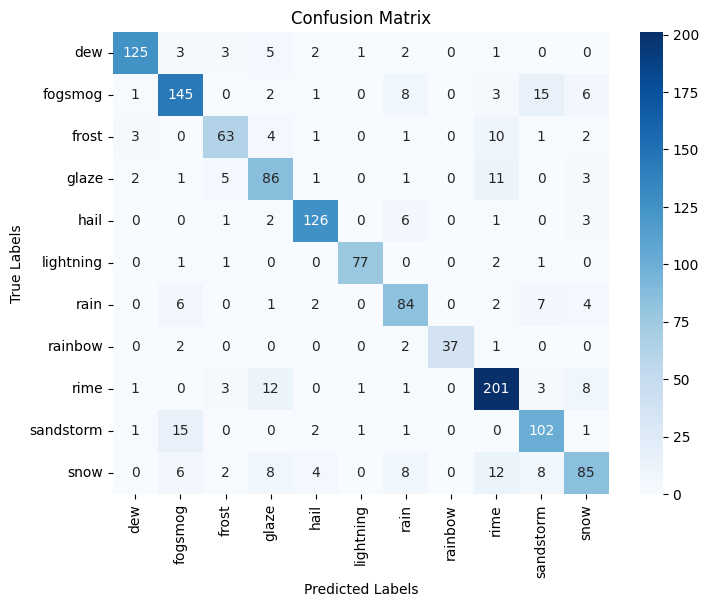


 Classification Report:

              precision    recall  f1-score   support

         dew       0.94      0.88      0.91       142
     fogsmog       0.81      0.80      0.81       181
       frost       0.81      0.74      0.77        85
       glaze       0.72      0.78      0.75       110
        hail       0.91      0.91      0.91       139
   lightning       0.96      0.94      0.95        82
        rain       0.74      0.79      0.76       106
     rainbow       1.00      0.88      0.94        42
        rime       0.82      0.87      0.85       230
   sandstorm       0.74      0.83      0.78       123
        snow       0.76      0.64      0.69       133

    accuracy                           0.82      1373
   macro avg       0.84      0.82      0.83      1373
weighted avg       0.83      0.82      0.82      1373


Training model Logistic Regression for features from EfficientNet


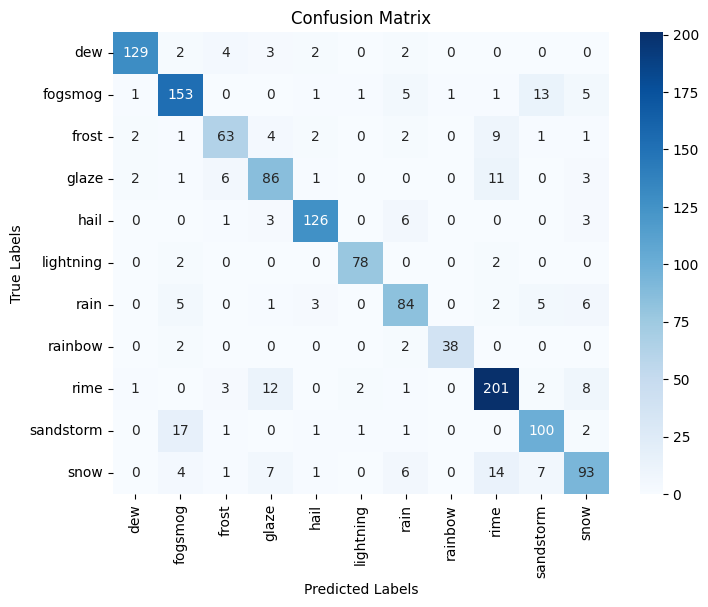


 Classification Report:

              precision    recall  f1-score   support

         dew       0.96      0.91      0.93       142
     fogsmog       0.82      0.85      0.83       181
       frost       0.80      0.74      0.77        85
       glaze       0.74      0.78      0.76       110
        hail       0.92      0.91      0.91       139
   lightning       0.95      0.95      0.95        82
        rain       0.77      0.79      0.78       106
     rainbow       0.97      0.90      0.94        42
        rime       0.84      0.87      0.86       230
   sandstorm       0.78      0.81      0.80       123
        snow       0.77      0.70      0.73       133

    accuracy                           0.84      1373
   macro avg       0.85      0.84      0.84      1373
weighted avg       0.84      0.84      0.84      1373


Training model Random Forest Regressor, n=50 for features from EfficientNet


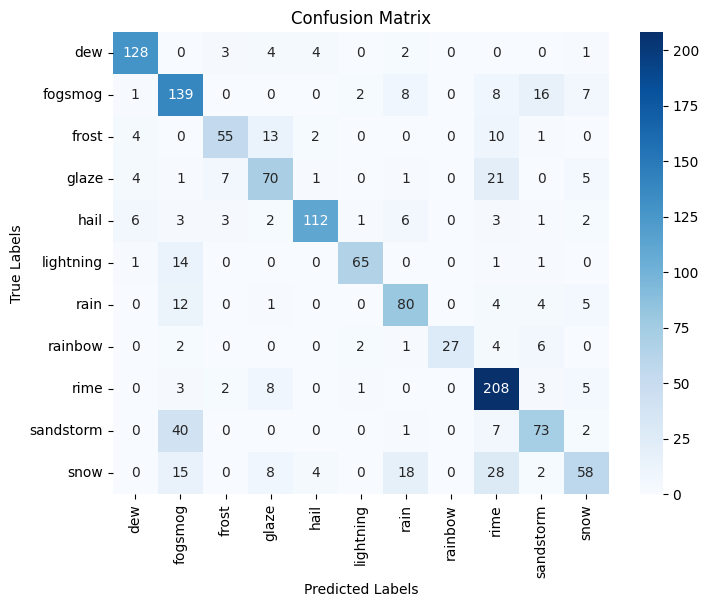


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.90      0.90       142
     fogsmog       0.61      0.77      0.68       181
       frost       0.79      0.65      0.71        85
       glaze       0.66      0.64      0.65       110
        hail       0.91      0.81      0.85       139
   lightning       0.92      0.79      0.85        82
        rain       0.68      0.75      0.72       106
     rainbow       1.00      0.64      0.78        42
        rime       0.71      0.90      0.79       230
   sandstorm       0.68      0.59      0.63       123
        snow       0.68      0.44      0.53       133

    accuracy                           0.74      1373
   macro avg       0.77      0.72      0.74      1373
weighted avg       0.75      0.74      0.74      1373


Training model Random Forest Regressor, n=100 for features from EfficientNet


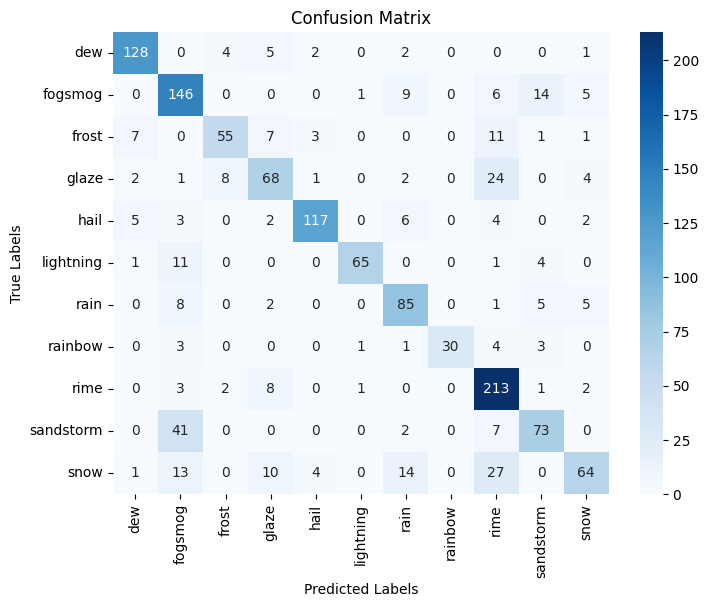


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.90      0.90       142
     fogsmog       0.64      0.81      0.71       181
       frost       0.80      0.65      0.71        85
       glaze       0.67      0.62      0.64       110
        hail       0.92      0.84      0.88       139
   lightning       0.96      0.79      0.87        82
        rain       0.70      0.80      0.75       106
     rainbow       1.00      0.71      0.83        42
        rime       0.71      0.93      0.81       230
   sandstorm       0.72      0.59      0.65       123
        snow       0.76      0.48      0.59       133

    accuracy                           0.76      1373
   macro avg       0.80      0.74      0.76      1373
weighted avg       0.77      0.76      0.76      1373


Training model SVM for features from Dinov2


c:\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


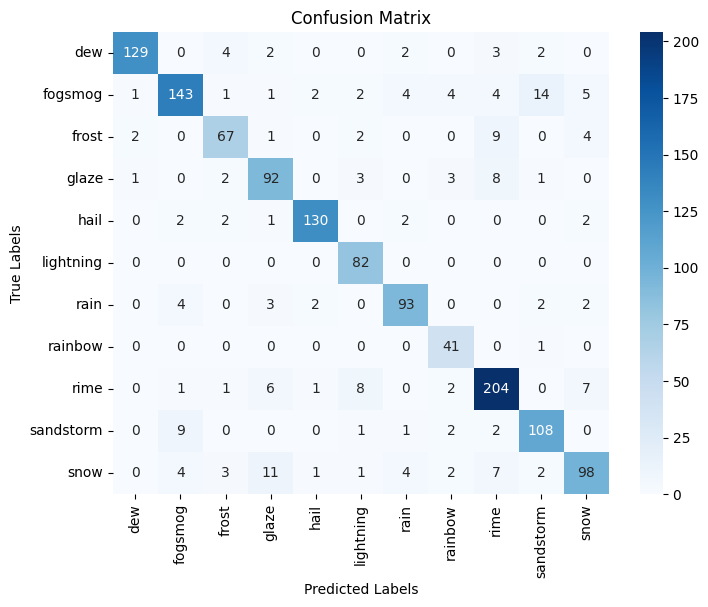


 Classification Report:

              precision    recall  f1-score   support

         dew       0.97      0.91      0.94       142
     fogsmog       0.88      0.79      0.83       181
       frost       0.84      0.79      0.81        85
       glaze       0.79      0.84      0.81       110
        hail       0.96      0.94      0.95       139
   lightning       0.83      1.00      0.91        82
        rain       0.88      0.88      0.88       106
     rainbow       0.76      0.98      0.85        42
        rime       0.86      0.89      0.87       230
   sandstorm       0.83      0.88      0.85       123
        snow       0.83      0.74      0.78       133

    accuracy                           0.86      1373
   macro avg       0.86      0.87      0.86      1373
weighted avg       0.87      0.86      0.86      1373


Training model Logistic Regression for features from Dinov2


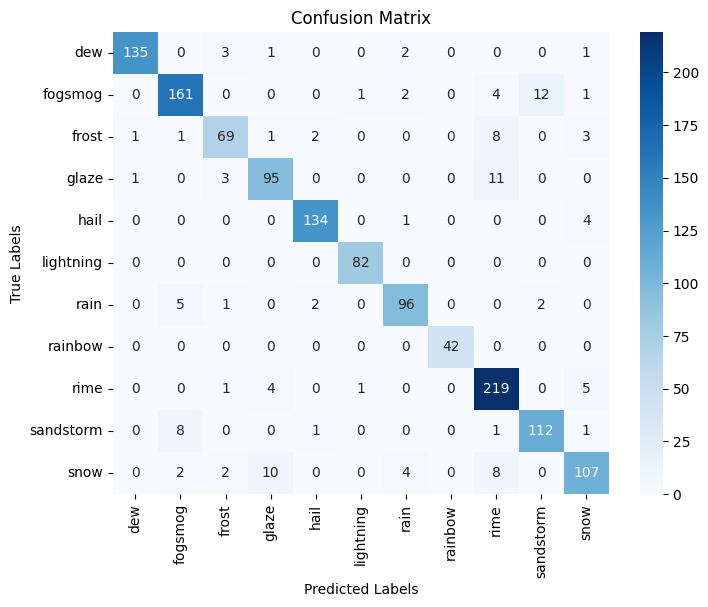


 Classification Report:

              precision    recall  f1-score   support

         dew       0.99      0.95      0.97       142
     fogsmog       0.91      0.89      0.90       181
       frost       0.87      0.81      0.84        85
       glaze       0.86      0.86      0.86       110
        hail       0.96      0.96      0.96       139
   lightning       0.98      1.00      0.99        82
        rain       0.91      0.91      0.91       106
     rainbow       1.00      1.00      1.00        42
        rime       0.87      0.95      0.91       230
   sandstorm       0.89      0.91      0.90       123
        snow       0.88      0.80      0.84       133

    accuracy                           0.91      1373
   macro avg       0.92      0.91      0.92      1373
weighted avg       0.91      0.91      0.91      1373


Training model Random Forest Regressor, n=50 for features from Dinov2


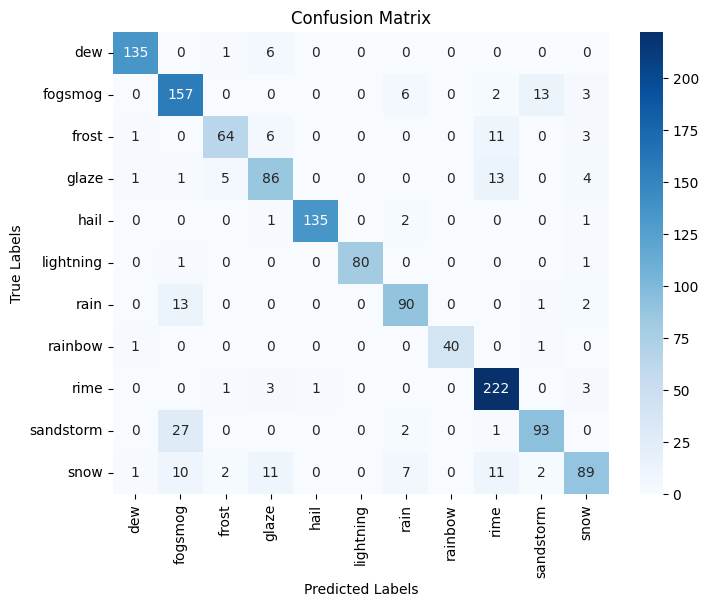


 Classification Report:

              precision    recall  f1-score   support

         dew       0.97      0.95      0.96       142
     fogsmog       0.75      0.87      0.81       181
       frost       0.88      0.75      0.81        85
       glaze       0.76      0.78      0.77       110
        hail       0.99      0.97      0.98       139
   lightning       1.00      0.98      0.99        82
        rain       0.84      0.85      0.85       106
     rainbow       1.00      0.95      0.98        42
        rime       0.85      0.97      0.91       230
   sandstorm       0.85      0.76      0.80       123
        snow       0.84      0.67      0.74       133

    accuracy                           0.87      1373
   macro avg       0.88      0.86      0.87      1373
weighted avg       0.87      0.87      0.87      1373


Training model Random Forest Regressor, n=100 for features from Dinov2


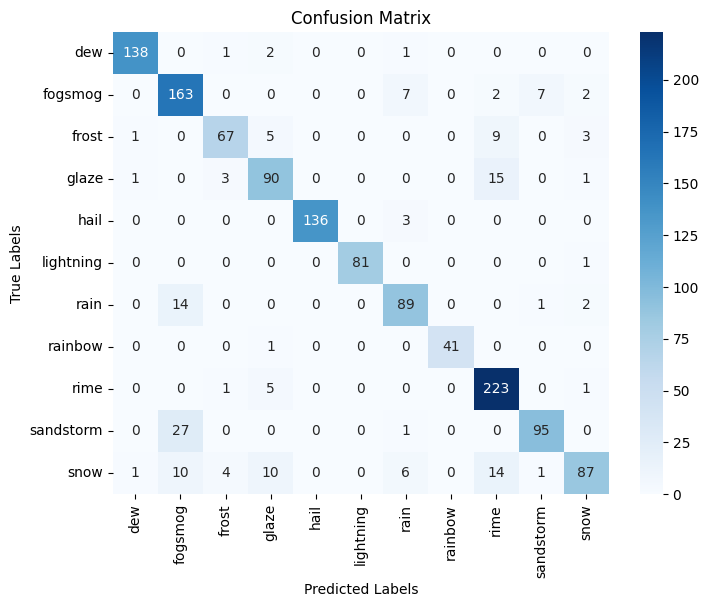


 Classification Report:

              precision    recall  f1-score   support

         dew       0.98      0.97      0.98       142
     fogsmog       0.76      0.90      0.83       181
       frost       0.88      0.79      0.83        85
       glaze       0.80      0.82      0.81       110
        hail       1.00      0.98      0.99       139
   lightning       1.00      0.99      0.99        82
        rain       0.83      0.84      0.84       106
     rainbow       1.00      0.98      0.99        42
        rime       0.85      0.97      0.90       230
   sandstorm       0.91      0.77      0.84       123
        snow       0.90      0.65      0.76       133

    accuracy                           0.88      1373
   macro avg       0.90      0.88      0.89      1373
weighted avg       0.89      0.88      0.88      1373


Training model SVM for features from Swin


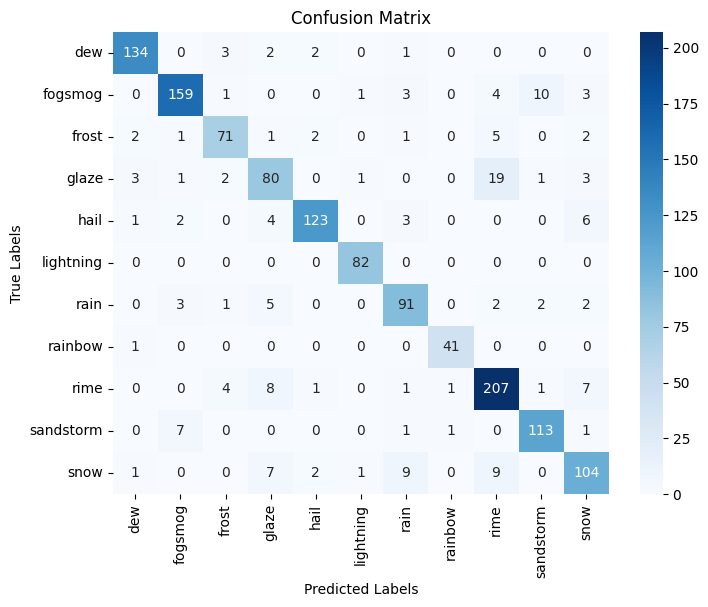


 Classification Report:

              precision    recall  f1-score   support

         dew       0.94      0.94      0.94       142
     fogsmog       0.92      0.88      0.90       181
       frost       0.87      0.84      0.85        85
       glaze       0.75      0.73      0.74       110
        hail       0.95      0.88      0.91       139
   lightning       0.96      1.00      0.98        82
        rain       0.83      0.86      0.84       106
     rainbow       0.95      0.98      0.96        42
        rime       0.84      0.90      0.87       230
   sandstorm       0.89      0.92      0.90       123
        snow       0.81      0.78      0.80       133

    accuracy                           0.88      1373
   macro avg       0.88      0.88      0.88      1373
weighted avg       0.88      0.88      0.88      1373


Training model Logistic Regression for features from Swin


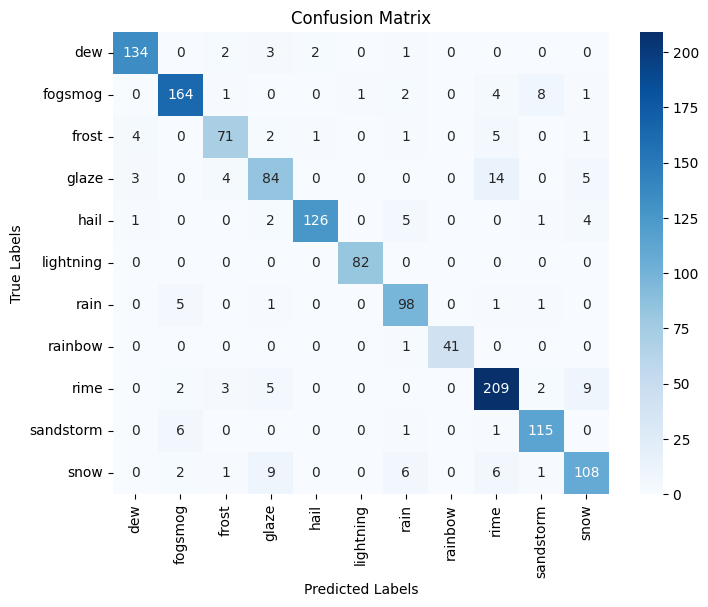


 Classification Report:

              precision    recall  f1-score   support

         dew       0.94      0.94      0.94       142
     fogsmog       0.92      0.91      0.91       181
       frost       0.87      0.84      0.85        85
       glaze       0.79      0.76      0.78       110
        hail       0.98      0.91      0.94       139
   lightning       0.99      1.00      0.99        82
        rain       0.85      0.92      0.89       106
     rainbow       1.00      0.98      0.99        42
        rime       0.87      0.91      0.89       230
   sandstorm       0.90      0.93      0.92       123
        snow       0.84      0.81      0.83       133

    accuracy                           0.90      1373
   macro avg       0.90      0.90      0.90      1373
weighted avg       0.90      0.90      0.90      1373


Training model Random Forest Regressor, n=50 for features from Swin


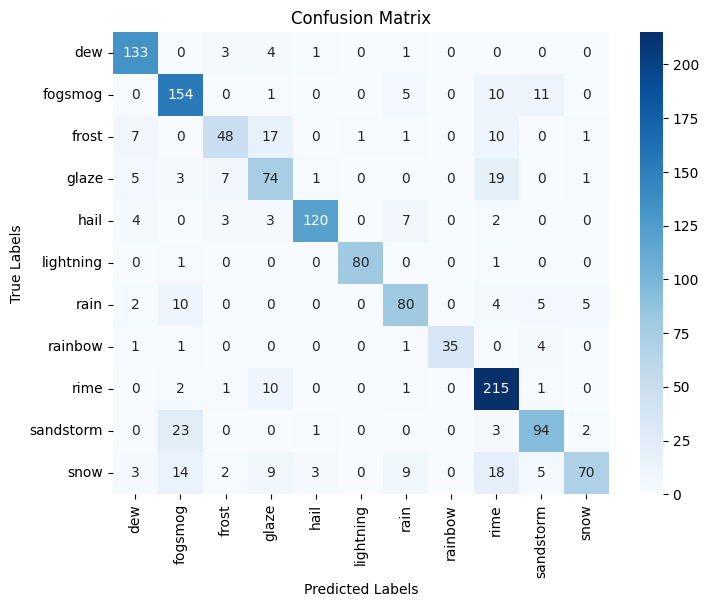


 Classification Report:

              precision    recall  f1-score   support

         dew       0.86      0.94      0.90       142
     fogsmog       0.74      0.85      0.79       181
       frost       0.75      0.56      0.64        85
       glaze       0.63      0.67      0.65       110
        hail       0.95      0.86      0.91       139
   lightning       0.99      0.98      0.98        82
        rain       0.76      0.75      0.76       106
     rainbow       1.00      0.83      0.91        42
        rime       0.76      0.93      0.84       230
   sandstorm       0.78      0.76      0.77       123
        snow       0.89      0.53      0.66       133

    accuracy                           0.80      1373
   macro avg       0.83      0.79      0.80      1373
weighted avg       0.81      0.80      0.80      1373


Training model Random Forest Regressor, n=100 for features from Swin


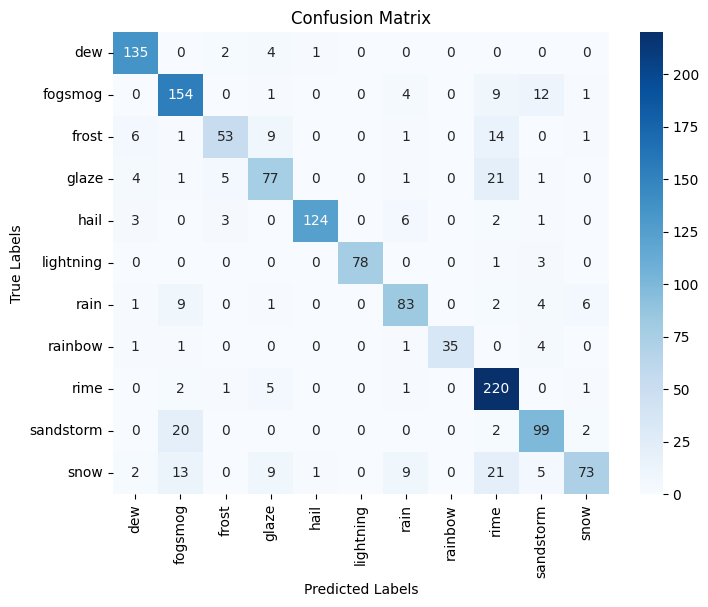


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.95      0.92       142
     fogsmog       0.77      0.85      0.81       181
       frost       0.83      0.62      0.71        85
       glaze       0.73      0.70      0.71       110
        hail       0.98      0.89      0.94       139
   lightning       1.00      0.95      0.97        82
        rain       0.78      0.78      0.78       106
     rainbow       1.00      0.83      0.91        42
        rime       0.75      0.96      0.84       230
   sandstorm       0.77      0.80      0.79       123
        snow       0.87      0.55      0.67       133

    accuracy                           0.82      1373
   macro avg       0.85      0.81      0.82      1373
weighted avg       0.83      0.82      0.82      1373


Training model SVM for features from Deit


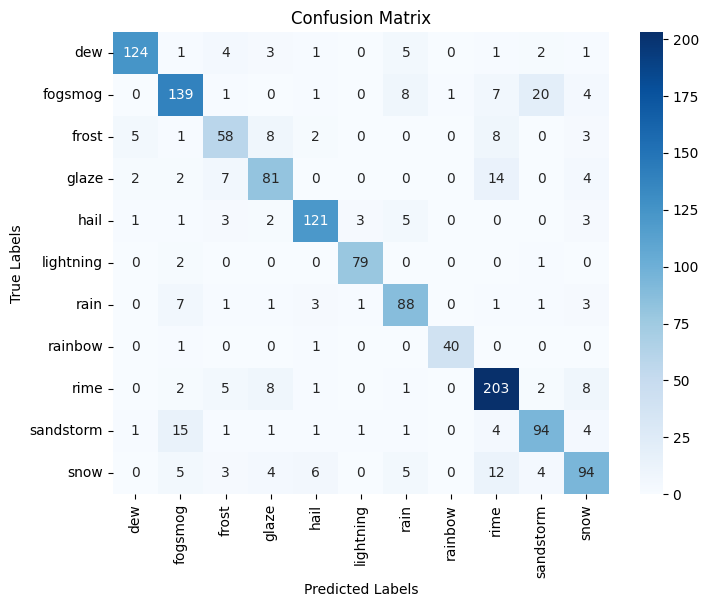


 Classification Report:

              precision    recall  f1-score   support

         dew       0.93      0.87      0.90       142
     fogsmog       0.79      0.77      0.78       181
       frost       0.70      0.68      0.69        85
       glaze       0.75      0.74      0.74       110
        hail       0.88      0.87      0.88       139
   lightning       0.94      0.96      0.95        82
        rain       0.78      0.83      0.80       106
     rainbow       0.98      0.95      0.96        42
        rime       0.81      0.88      0.85       230
   sandstorm       0.76      0.76      0.76       123
        snow       0.76      0.71      0.73       133

    accuracy                           0.82      1373
   macro avg       0.83      0.82      0.82      1373
weighted avg       0.82      0.82      0.82      1373


Training model Logistic Regression for features from Deit


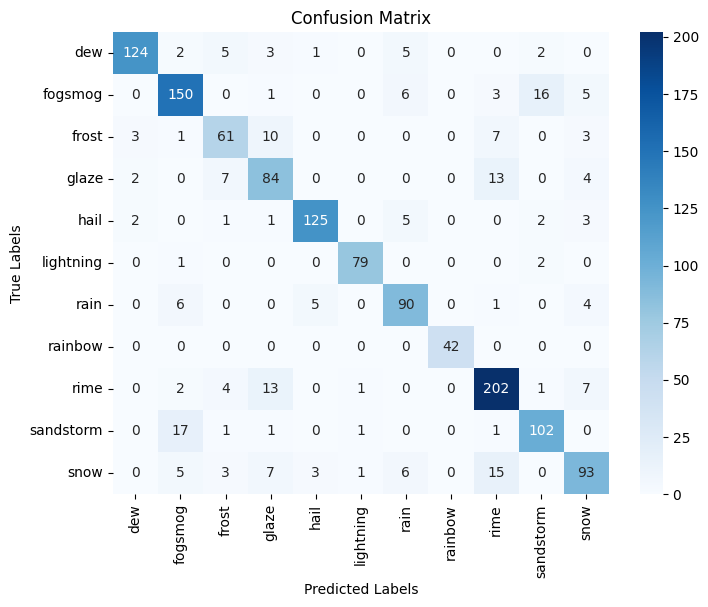


 Classification Report:

              precision    recall  f1-score   support

         dew       0.95      0.87      0.91       142
     fogsmog       0.82      0.83      0.82       181
       frost       0.74      0.72      0.73        85
       glaze       0.70      0.76      0.73       110
        hail       0.93      0.90      0.92       139
   lightning       0.96      0.96      0.96        82
        rain       0.80      0.85      0.83       106
     rainbow       1.00      1.00      1.00        42
        rime       0.83      0.88      0.86       230
   sandstorm       0.82      0.83      0.82       123
        snow       0.78      0.70      0.74       133

    accuracy                           0.84      1373
   macro avg       0.85      0.85      0.85      1373
weighted avg       0.84      0.84      0.84      1373


Training model Random Forest Regressor, n=50 for features from Deit


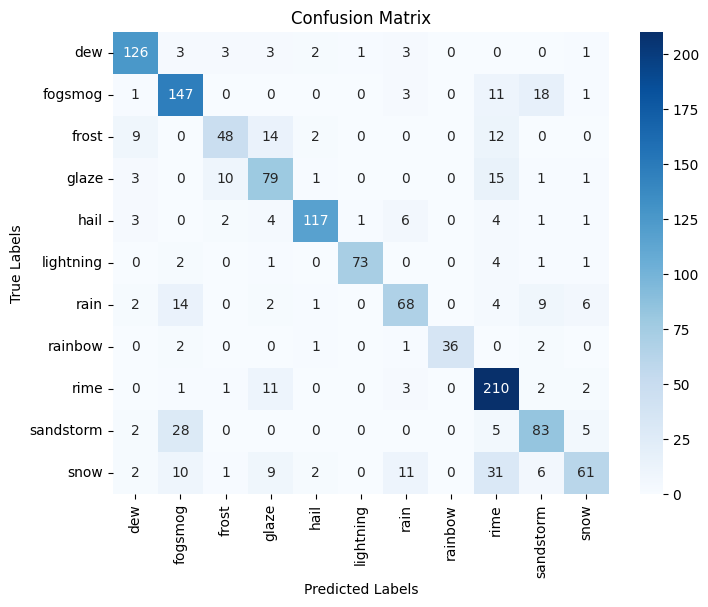


 Classification Report:

              precision    recall  f1-score   support

         dew       0.85      0.89      0.87       142
     fogsmog       0.71      0.81      0.76       181
       frost       0.74      0.56      0.64        85
       glaze       0.64      0.72      0.68       110
        hail       0.93      0.84      0.88       139
   lightning       0.97      0.89      0.93        82
        rain       0.72      0.64      0.68       106
     rainbow       1.00      0.86      0.92        42
        rime       0.71      0.91      0.80       230
   sandstorm       0.67      0.67      0.67       123
        snow       0.77      0.46      0.58       133

    accuracy                           0.76      1373
   macro avg       0.79      0.75      0.76      1373
weighted avg       0.77      0.76      0.76      1373


Training model Random Forest Regressor, n=100 for features from Deit


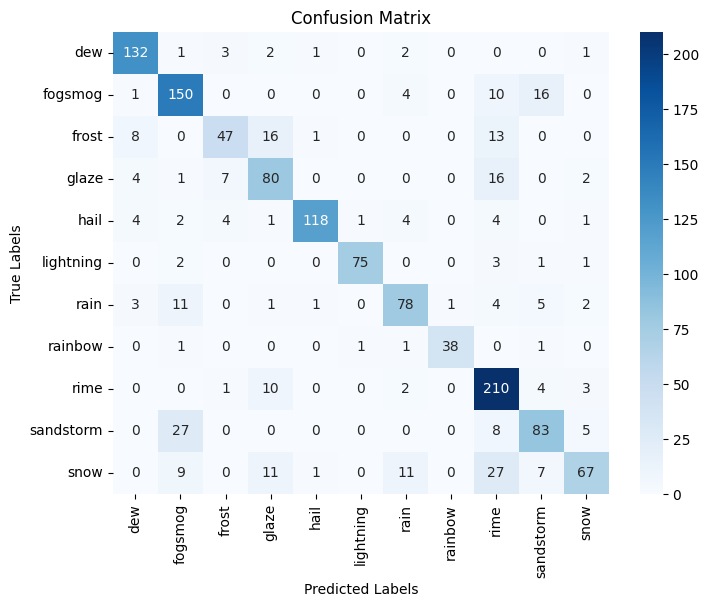


 Classification Report:

              precision    recall  f1-score   support

         dew       0.87      0.93      0.90       142
     fogsmog       0.74      0.83      0.78       181
       frost       0.76      0.55      0.64        85
       glaze       0.66      0.73      0.69       110
        hail       0.97      0.85      0.90       139
   lightning       0.97      0.91      0.94        82
        rain       0.76      0.74      0.75       106
     rainbow       0.97      0.90      0.94        42
        rime       0.71      0.91      0.80       230
   sandstorm       0.71      0.67      0.69       123
        snow       0.82      0.50      0.62       133

    accuracy                           0.79      1373
   macro avg       0.81      0.78      0.79      1373
weighted avg       0.79      0.79      0.78      1373



[None, None, None, None]

In [29]:
data_arr = [
    [features_imgnet, "EfficientNet"],
    [features_dinov2, "Dinov2"],
    [features_swin, "Swin"],
    [features_deit, "Deit"]
]

print(labels.shape)
[print(f"Num features of model {data[1]}: {data[0].shape}") for data in data_arr]
[classify(data[0], labels, data[1]) for data in data_arr]

# Kết quả

## Tổng quan

Tổng số mẫu: 6,862

Các lớp: 11 hiện tượng thời tiết  
+ sương đọng (dew)  
+ sương mù/khói mù (fogsmog)  
+ sương giá (frost)  
+ băng phủ (glaze)  
+ mưa đá (hail)  
+ sét (lightning)  
+ mưa (rain)  
+ cầu vồng (rainbow)  
+ băng kết tinh (rime)  
+ bão cát (sandstorm)  
+ tuyết (snow)

## Quy trình

Mỗi hình ảnh được đưa qua một bộ trích xuất đặc trưng trước khi vào phần đầu phân loại cổ điển.

Các đặc trưng đã trích xuất có thể được tìm thấy trong thư mục ```./features``` cho tất cả các bộ trích xuất đặc trưng liên quan.

## Bộ trích xuất đặc trưng

| Mô hình              | Kích thước đặc trưng | Mô tả                                               |
| :------------------- | :------------------: | :-------------------------------------------------- |
| **EfficientNet**     |       1,536          | Dựa trên CNN, cơ sở mạnh cho đặc trưng thị giác     |
| **DINOv2**           |        384           | ViT tự giám sát, đặc trưng mang tính ngữ nghĩa cao  |
| **Swin Transformer** |        768           | Transformer phân cấp, hiểu tốt về không gian        |
| **DeiT**             |        384           | Vision Transformer hiệu quả về dữ liệu              |

## Bộ phân loại

Mỗi bộ trích xuất được đánh giá với ba bộ phân loại cổ điển:

+ SVM (Support Vector Machine)  
+ Hồi quy Logistic  
+ Rừng ngẫu nhiên (Random Forest) (n=50 và n=100)

## So sánh độ chính xác kết quả

| Bộ trích xuất đặc trưng |  SVM | Hồi quy Logistic | Rừng ngẫu nhiên (k = 50) | Rừng ngẫu nhiên (k = 100) |
| :----------------------- | :--: | :---------------: | :----------------: | :-----------------: |
| **EfficientNet**         | 0.83 |       0.84        |        0.74        |         0.76        |
| **DINOv2**               | 0.87 |     **0.91**      |        0.87        |         0.88        |
| **Swin**                 | 0.88 |     **0.90**      |        0.80        |         0.82        |
| **DeiT**                 | 0.82 |       0.84        |        0.76        |         0.79        |

## Cấu hình hoạt động tốt nhất

| Bộ trích xuất       | Bộ phân loại             | Độ chính xác | Macro F1 | Weighted F1 | Ghi chú                                                   |
| :------------------ | :----------------------- | :----------- | :------- | :---------- | :-------------------------------------------------------- |
| **DINOv2**          | **Hồi quy Logistic**     | **0.91**     | 0.92     | 0.91        | Cân bằng tuyệt vời giữa recall & precision cho mọi lớp    |
| **Swin**            | Hồi quy Logistic         | 0.90         | 0.90     | 0.90        | Transformer cạnh tranh, khả năng khái quát mạnh mẽ        |
| **DINOv2**          | Rừng ngẫu nhiên (100)    | 0.88         | 0.89     | 0.88        | Kết quả rất ổn định                                       |
| **EfficientNet**    | Hồi quy Logistic         | 0.84         | 0.84     | 0.84        | Cơ sở tốt nhất dựa trên CNN                               |
| **DeiT**            | Hồi quy Logistic         | 0.84         | 0.85     | 0.84        | Ổn định nhưng hơi yếu hơn so với DINOv2/Swin              |

## Ghi chú về hiệu suất

### Bộ trích xuất CNN (EfficientNet)

1. EfficientNet cung cấp kết quả nền vững chắc.  
2. Mô hình hoạt động tốt nhất với Hồi quy Logistic.  
3. Độ chính xác thấp hơn một chút so với các bộ trích xuất dựa trên Transformer, phản ánh lợi thế biểu diễn của đặc trưng kiểu ViT (Vision Transformer).

### Bộ trích xuất dựa trên Transformer (DINOv2, Swin, DeiT)

1. **DINOv2**: Cho hiệu suất tổng thể tốt nhất, nhờ đặc trưng tự giám sát mang tính ngữ nghĩa mạnh.  
2. **Swin**: Hiệu suất gần với **DINOv2**, thấp hơn một chút về macro F1 nhưng có độ nhất quán recall cao giữa các lớp.  
3. **DeiT**: Kết quả cạnh tranh với vector đặc trưng nhỏ hơn, cho thấy hiệu quả tốt hơn trên tập dữ liệu vừa phải.

### Rừng ngẫu nhiên

+ Độ chính xác của rừng ngẫu nhiên tăng nhẹ từ 50 → 100 cây (cho thấy chưa đạt ngưỡng “bão hòa”). Tuy nhiên, trung bình vẫn thấp hơn ~10% so với SVM hoặc Hồi quy Logistic.  
+ Rừng ngẫu nhiên có recall cao hơn với các lớp xuất hiện thường xuyên (như rime, fogsmog) nhưng precision giảm dần với các lớp nhỏ hơn (snow, rainbow).

### Ghi chú tổng quát

+ DINOv2 + Hồi quy Logistic đạt độ chính xác cao nhất (91%) và macro F1 (0.92).  
+ Swin + Hồi quy Logistic đứng thứ hai sát nút (90% chính xác). Cần thêm dữ liệu kiểm thử để xác định mô hình nào tổng quát tốt hơn.  
+ Các mô hình Rừng ngẫu nhiên kém hiệu quả hơn với các vector đặc trưng kích thước lớn, có thể do chiến lược chia nhánh thông thường không nắm bắt tốt các đặc trưng phức tạp trong không gian nhúng cao.  
+ SVM và Hồi quy Logistic xử lý hiệu quả các vector nhúng nhiều chiều và tổng quát tốt hơn. Đặc biệt Hồi quy Logistic cho thấy dữ liệu trở nên gần tuyến tính trong không gian đặc trưng mới.  
+ Các đặc trưng dựa trên Transformer vượt trội hơn các đặc trưng CNN trong nhận dạng hiện tượng thời tiết đa dạng, cho thấy sức mạnh của cơ chế tự giám sát và chú ý phân cấp trong việc nhúng dữ liệu cho nhiệm vụ này.

## Tóm tắt 5 kết quả hàng đầu của bộ trích xuất + bộ phân loại
| Bộ trích xuất       | Bộ phân loại             | Độ chính xác | Macro F1 | Weighted F1 | Ghi chú                                                   |
| :------------------ | :----------------------- | :----------- | :------- | :---------- | :-------------------------------------------------------- |
| **DINOv2**          | **Hồi quy Logistic**     | **0.91**     | 0.92     | 0.91        | Cân bằng tuyệt vời giữa recall & precision cho mọi lớp    |
| **Swin**            | Hồi quy Logistic         | 0.90         | 0.90     | 0.90        | Transformer cạnh tranh, khả năng khái quát mạnh mẽ        |
| **DINOv2**          | Rừng ngẫu nhiên (100)    | 0.88         | 0.89     | 0.88        | Kết quả rất ổn định                                       |
| **EfficientNet**    | Hồi quy Logistic         | 0.84         | 0.84     | 0.84        | Cơ sở tốt nhất dựa trên CNN                               |
| **DeiT**            | Hồi quy Logistic         | 0.84         | 0.85     | 0.84        | Ổn định nhưng hơi yếu hơn so với DINOv2/Swin              |


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu từ báo cáo của bạn
extractors = ['EfficientNet', 'DINOv2', 'Swin', 'DeiT']
svm_scores = [0.83, 0.87, 0.88, 0.82]
lr_scores = [0.84, 0.91, 0.90, 0.84]
rf50_scores = [0.74, 0.87, 0.80, 0.76]
rf100_scores = [0.76, 0.88, 0.82, 0.79]

x = np.arange(len(extractors))
width = 0.2  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - 1.5*width, svm_scores, width, label='SVM', color='#6c757d')
rects2 = ax.bar(x - 0.5*width, lr_scores, width, label='Logistic Regression', color='#0d6efd')
rects3 = ax.bar(x + 0.5*width, rf50_scores, width, label='Random Forest (n=50)', color='#ffc107')
rects4 = ax.bar(x + 1.5*width, rf100_scores, width, label='Random Forest (n=100)', color='#198754')

# Trang trí biểu đồ
ax.set_ylabel('Độ chính xác (Accuracy)', fontsize=12)
ax.set_title('So sánh Hiệu năng: Bộ trích xuất vs Bộ phân loại', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(extractors, fontsize=11)
ax.set_ylim(0.7, 1.0)
ax.legend(loc='lower right', title='Classifiers')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Hàm thêm nhãn số liệu lên cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.savefig('btl3_grouped_chart.png')
plt.close()
print("Đã tạo ảnh: btl3_grouped_chart.png")

Đã tạo ảnh: btl3_grouped_chart.png
